In order to test for weaknesses of SciNet, I will turn to physical problems that have solution functions that are difficult for Deep Learning - specifically, rapid changs and discontinuities. I also wanted a problem that was ubiquitous and basic in Physics, so that I could not be accused of throwing some esoteric, unnatural, and difficult problem at the system, such as predicting the shapes of Lyapunov tongues or tracing out strange attractors.

Since the original authors had explicitly developed models for the simple damped oscillator, I figured that the driven damped oscillator was a natural choice.

## The Driven Damped Oscillator

The simplest damped driven oscillator, which captures the central features of the response without any unnecessary scaling factors, can be written using the equations

$$
\ddot{x} + 2 \gamma \dot{x} + x = \cos{\omega t}
$$

For the sake of simplicy, we'll stay with the underdamped case $\gamma < 1$.

The dynamics of this differential equation are entirely captured by the damping $\gamma$ and the driving frequence $\omega$. This statement of the problem avoids questions of the fundamental frequency of the original oscillator, spring constant, or driving amplitude, since all of these only scale the problem in $x$ or $t$.

The stable solution to this differential equations is 
$$
x(t) = A \cos (\omega t - \phi ) \\
\tan{\phi} = \frac{2\gamma \omega}{1 - \omega^2} \text{ , } 0 \le \phi \le \pi \\
A = \frac{1}{\sqrt{4\gamma^2\omega^2 + [1 - \omega^2]^2}}
$$

## Python Functions

Let us now write python functions to compute both of these equations, and plot them, so that we can discuss the central features of this problem.

In [1]:
import math
import numpy as np

def phi(w,b):
    """Computes phase.
    w = \omega, b = \gamma
    Both can be numpy arrays, for convenience."""
    return np.arctan2(2*w*b,(1-w**2))

def amplitude(w, b):
    """Computes amplitude.
    w = \omega, b = \gamma
    Both can be numpy arrays, for convenience."""
    return 1.0/np.sqrt(4*(w**2)*(b**2) + (1 - w**2)**2)

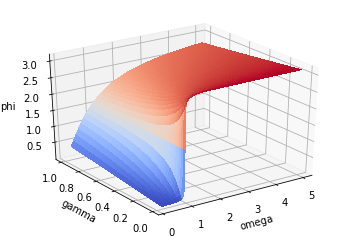

In [3]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm

w = np.arange(0.2, 5.0, 0.01)
b = np.arange(0.01, 1.0, 0.01)

W, B = np.meshgrid(w, b)
Phi = phi(W, B)

fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.plot_surface(W, B, Phi, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.view_init(30, 235)
ax.set_xlabel("omega")
ax.set_ylabel("gamma")
ax.set_zlabel("phi")

fig

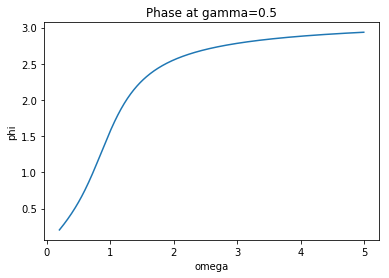

In [5]:
#This is easier to understand by plotting several crossections.
#This is high damping \omega dependence:

b = 0.5
w = np.arange(0.2, 5.0, 0.01)
Phi = phi(w, b)

fig = plt.figure()
a = plt.plot(w, Phi)

plt.xlabel("omega")
plt.ylabel("phi")
plt.title("Phase at gamma=0.5")

fig

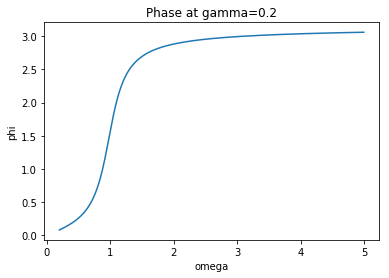

In [6]:
#Medium damping

b = 0.2
w = np.arange(0.2, 5.0, 0.01)
Phi = phi(w, b)

fig = plt.figure()
a = plt.plot(w, Phi)

plt.xlabel("omega")
plt.ylabel("phi")
plt.title("Phase at gamma=0.2")

fig

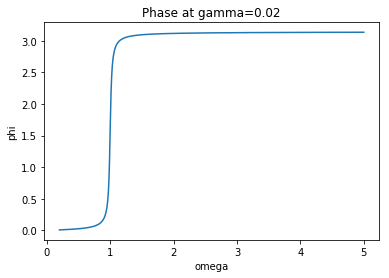

In [7]:
# And low damping.

b = 0.02
w = np.arange(0.2, 5.0, 0.001)
Phi = phi(w, b)

fig = plt.figure()
a = plt.plot(w, Phi)

plt.xlabel("omega")
plt.ylabel("phi")
plt.title("Phase at gamma=0.02")

fig

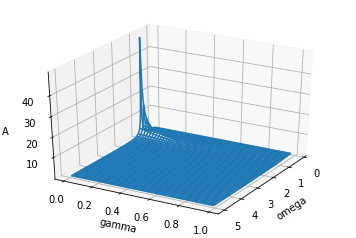

In [8]:
# Now let's examine amplitude. Notice the resonant peak.

w = np.arange(0.2, 5.0, 0.01)
b = np.arange(0.01, 1.0, 0.01)
W, B = np.meshgrid(w, b)

A = amplitude(W, B)

fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.plot_wireframe(W, B, A)

ax.set_xlabel("omega")
ax.set_ylabel("gamma")
ax.set_zlabel("A")

ax.view_init(30, 30)
#Notice the sharp peak near resonance.
fig

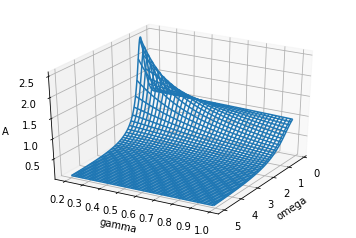

In [9]:
# Zooming in on a higher damped region, so we can see the behavior away from the peak.

w = np.arange(0.2, 5.0, 0.01)
b = np.arange(0.2, 1.0, 0.01)
W, B = np.meshgrid(w, b)

A = amplitude(W, B)

fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.plot_wireframe(W, B, A)
ax.view_init(30, 30)

ax.set_xlabel("omega")
ax.set_ylabel("gamma")
ax.set_zlabel("A")

fig

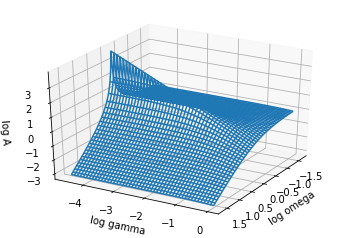

In [10]:
# And now in log space, for clarity.

w = np.arange(np.log(0.2), np.log(5.0), 0.01)
b = np.arange(np.log(0.01), np.log(1.0), 0.1)
W, B = np.meshgrid(w, b)

A = np.log(amplitude(np.exp(W), np.exp(B)))

fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.plot_wireframe(W, B, A)
ax.view_init(30, 30)

ax.set_xlabel("log omega")
ax.set_ylabel("log gamma")
ax.set_zlabel("log A")

fig

## The Problem

Clearly, these functionos are not as clean and smooth as the typical functions used in combination with NNs. There is a sharp $\phi$ discontinuity at $\omega = 1, \gamma = 0$, for instance, and $A$ suffers from a very large peak near $\omega = 1, \gamma = 0$ (thanks to resonance). Even viewed logarithmically, there is a clear "crease."

Neural nets with ReLU layers might handle this decently, but smooth ELU layers will almost certainly suffer in performance. I am going to sample using a displaced normal around certain different points (including the discontinuities themselves) and check interpolation / extrapolation. I'm expecting decent interpolation in some areas, but no "natural quantities" in the latent space, and certainly no quality extrapolation.

### Why no time dependence?

In the original oscilator, the authors work with a system that changes over time. It would certainly be possible to do that here, as well; in fact, if I have time, I will. However, that is a far simpler problem: SciNet would only really have to learn numerical integration, instead of a complex interdependence between the variables.

However, the setup I am using is not unnatural, because we often work with oscillators whose natural frequency is far greater from the frequency of observation (such as electrical / quantum systems), and all we have available is the average intensity of the steady state signal. This is a ubiquitous setup, and I am hoping to show that the system is utterly unprepared to model / predict such an important phenomenon as resonant peaks.